In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [2]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv')

In [3]:
train['room_coor_x'] = train['room_coor_x'].fillna(0)
train['room_coor_y'] = train['room_coor_y'].fillna(0)
train['screen_coor_x'] = train['screen_coor_x'].fillna(0)
train['screen_coor_y'] = train['screen_coor_y'].fillna(0)
train['hover_duration'] = train['hover_duration'].fillna(0)
train['page'] = train['page'].fillna(-1)
train['page'] = train['page']+1

In [4]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB! The idea for EVENTS feature is from [here][1]

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [5]:
NUNIQUE = ['fqid', 'room_fqid', 'text']
COUNT = ['fqid','text']
MMS = ['elapsed_time', 'hover_duration','index'] 
MEAN = ['level']
STD = ['room_coor_x', 'room_coor_y','screen_coor_x','screen_coor_y']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click','notification_click','map_click','observation_click',
          'checkpoint','notebook_click']
SUM = ['index','page']

In [6]:
def feature_engineer(train):
    dfs = []
    for c in NUNIQUE:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in COUNT:
        tmp = train.groupby(['session_id','level_group'])[c].agg('count')
        tmp.name = tmp.name + '_count'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    for c in MMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in MEAN:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in STD:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in SUM:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in EVENTS:
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
    df = pd.concat(dfs,axis=1)
    # df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(35337, 32)
CPU times: user 1min 5s, sys: 994 ms, total: 1min 6s
Wall time: 1min 6s


,level_group,fqid_nunique,room_fqid_nunique,text_nunique,fqid_count,text_count,elapsed_time_max,hover_duration_max,index_max,elapsed_time_min,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,notebook_click_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,30,7,56,104,62,194860,7899.0,164,0,...,81.0,22.0,28.0,11.0,8,2.0,4,1,0.0,14155937
20090312431273200,13-22,49,12,168,313,196,1272679,4750.0,931,836732,...,170.0,123.0,60.0,20.0,10,6.0,3,1,0.0,437052322
20090312431273200,5-12,39,11,124,235,126,499235,4183.0,470,221485,...,103.0,104.0,12.0,28.0,9,8.0,1,1,0.0,105732736
20090312433251036,0-4,22,6,49,97,61,233752,5567.0,138,0,...,49.0,18.0,36.0,15.0,5,3.0,2,1,2.0,13571045
20090312433251036,13-22,73,16,183,762,229,3815334,22351.0,1875,1176483,...,637.0,145.0,65.0,83.0,14,45.0,5,1,50.0,3241011333


# Train XGBoost Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [8]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 31 features
We will train with 11779 users info


You can also use grid search and Bayesian optimization methods

In [9]:
gkf = GroupKFold(n_splits=20)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print(' ')
    print('Fold',i+1)
    print(' ')
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1500,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

 
Fold 1
 
1(206), 2(198), 3(210), 4(161), 5(65), 6(65), 7(179), 8(45), 9(166), 10(193), 11(147), 12(56), 13(58), 14(112), 15(145), 16(89), 17(63), 18(218), 
 
Fold 2
 
1(250), 2(80), 3(148), 4(136), 5(89), 6(76), 7(167), 8(59), 9(77), 10(105), 11(88), 12(73), 13(103), 14(97), 15(76), 16(46), 17(47), 18(121), 
 
Fold 3
 
1(301), 2(87), 3(216), 4(192), 5(71), 6(76), 7(55), 8(32), 9(127), 10(81), 11(130), 12(77), 13(116), 14(72), 15(85), 16(172), 17(118), 18(168), 
 
Fold 4
 
1(177), 2(137), 3(90), 4(181), 5(123), 6(122), 7(138), 8(49), 9(37), 10(130), 11(73), 12(68), 13(57), 14(82), 15(114), 16(77), 17(63), 18(101), 
 
Fold 5
 
1(245), 2(287), 3(106), 4(187), 5(60), 6(117), 7(114), 8(49), 9(368), 10(83), 11(76), 12(155), 13(60), 14(202), 15(204), 16(109), 17(79), 18(69), 
 
Fold 6
 
1(219), 2(106), 3(143), 4(192), 5(133), 6(109), 7(132), 8(159), 9(144), 10(144), 11(56), 12(113), 13(167), 14(170), 15(232), 16(171), 17(59), 18(91), 
 
Fold 7
 
1(410), 2(120), 3(189), 4(130), 5(127), 6(79)

# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [10]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [11]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

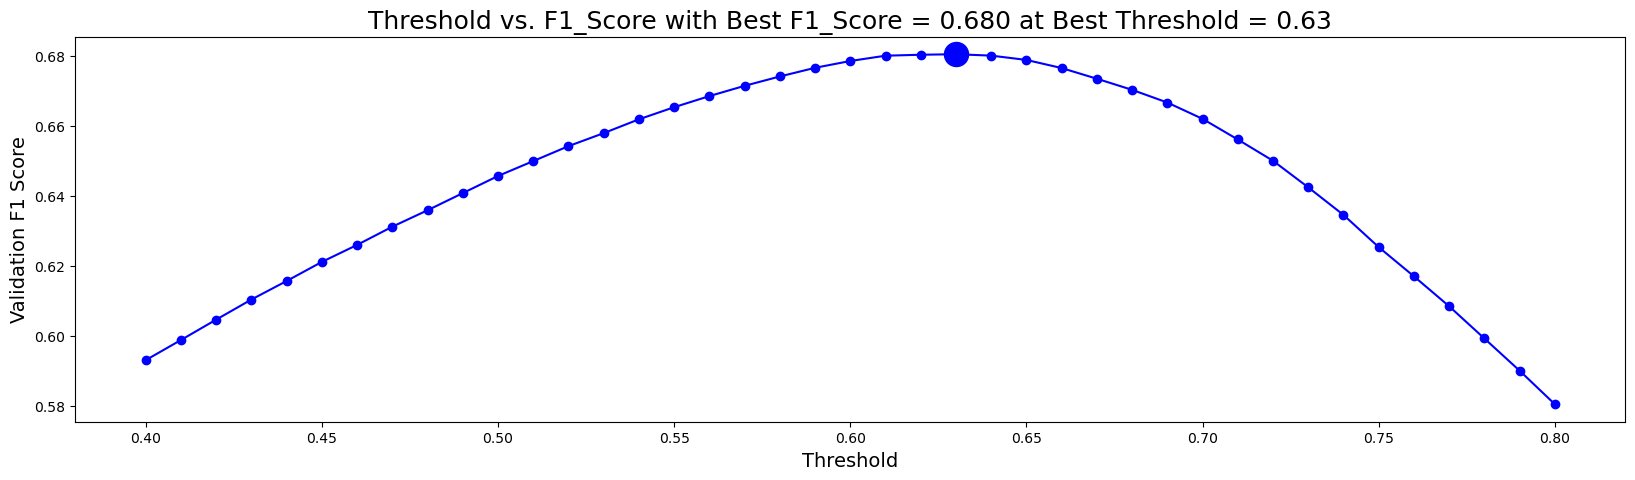

In [12]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [13]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6197877554039982
Q1: F1 = 0.4985674586786496
Q2: F1 = 0.4883161851366258
Q3: F1 = 0.6171113890583693
Q4: F1 = 0.5712212029891377
Q5: F1 = 0.611246209730208
Q6: F1 = 0.6005659976366139
Q7: F1 = 0.520123702042622
Q8: F1 = 0.6032591703088215
Q9: F1 = 0.49512107392050975
Q10: F1 = 0.5921726785023027
Q11: F1 = 0.5027866194416898
Q12: F1 = 0.44049739691502227
Q13: F1 = 0.6187999842591747
Q14: F1 = 0.49825565262783333
Q15: F1 = 0.4698529990025296
Q16: F1 = 0.5505469910365791
Q17: F1 = 0.4937735575108168
==> Overall F1 = 0.6804770559345443


# Infer Test Data

In [14]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del train, targets, df, oof, true
_ = gc.collect()

In [15]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    test['room_coor_x'].fillna(0)
    test['room_coor_y'].fillna(0)
    test['screen_coor_y'].fillna(0)
    test['screen_coor_x'].fillna(0)
    test['hover_duration'].fillna(0)
    test['page'].fillna(-1)
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# EDA submission.csv

In [16]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,1
4,20090312143683264_q2,1


In [17]:
print(df.correct.mean())

0.5555555555555556
